# Statistical Analysis of Bachelor Data

##Import Dependencies

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams


import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import requests
import json
import math

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import *

from sklearn.metrics import roc_curve, auc

# import helper commands
from helpers import *


## Import Data

In [2]:
#Import all data sources

#Data for each contestant broken down by seasons
with open('tempdata/seasonsDict.json') as json_file:
    seasonsDict = json.load(json_file)

#Twitter
with open("twitter_sentiment.json") as json_file:
    twitter = json.load(json_file)
    
#Distances
with open("distances.json") as json_file:
    distances = json.load(json_file)
    
#Geo-Cluster
with open("geo_cluster.json") as json_file:
    geo_cluster = json.load(json_file)
    
#Profession
with open("profession_dict.json") as json_file:
    professions = json.load(json_file)
    
#Wiki Info
wiki = pd.read_csv("contestantDF.csv")

#Date Guide
date_guide = pd.read_csv("date_guide.csv")

# PCA data 
with open('pca_dict.json') as json_file:
    raw_pca_data = json.load(json_file)

pca_data = {}
for sn in distances:
    pca_data[sn] = {}
    for contestant in distances[sn]:
        for c in raw_pca_data[sn]:
            if c in contestant:
                pca_data[sn][contestant] = raw_pca_data[sn][c]

#Competition Data
with open("competition_data.json") as json_file:
    comp = json.load(json_file)

## Aggregate Data to be Used in DF

In [3]:
# Organize all the data into a single list
contestants = []
for sn in seasonsDict:
    if int(sn) > 12: # only add data from seasons 13 and on
        for contestant in seasonsDict[sn]:
            cname = contestant['name']
            # add twitter data to contestants info
            foundTwitterName = False
            for tname in twitter[sn]:
                if tname in cname:
                    if len(twitter[sn][tname]) > 0:
                        ntweets = []
                        tweetSentiment = []
                        for date in twitter[sn][tname]:
                            ntweets.append(twitter[sn][tname][date]['ntweet'])
                            tweetSentiment.append(twitter[sn][tname][date]['sentiment'])
                        contestant['avg_num_tweets'] = np.mean(ntweets)
                        contestant['total_tweets'] = np.sum(ntweets)
                        contestant['avg_tweet_sentiment'] = np.mean(tweetSentiment)
                        contestant['total_tweet_sentiment'] = np.sum(tweetSentiment)
                    else:
                        contestant['avg_num_tweets'] = 0
                        contestant['total_tweets'] =0
                        contestant['avg_tweet_sentiment'] = 0
                        contestant['total_tweet_sentiment'] = 0
            
            if cname in distances[sn]:
                # add distance data 
                contestant['distance'] = distances[sn][cname]

                # add profession data

                contestant['profession'] = professions[sn][cname]

                # add geo cluster data 
                contestant['geo_cluster'] = geo_cluster[sn][cname]
                if cname in pca_data[sn]:
                    contestant['pc1'], contestant['pc2'] = pca_data[sn][cname]
                
                contestants.append(contestant)


## Generate DF for All Data

In [31]:
# Create data frame from the contestants dictionary
df = pd.DataFrame(contestants)

# get rid of an samples that contain NaN
#df = df.dropna()
# just in case, we drop any duplicate samples 
df = df.drop_duplicates()
# get rid of the samples for bachelors
df = df[df.elimination != 'unknown']
# create a column for 'won' to indicate whether the contestant won or did not 
df['won'] = (df.elimination == 'Winner')*1
df['runner_up'] = (df.elimination == 'Runner-up')*1
# winners and runners up are currently strings. We need to turn them into integers
df['elimination'] = df['elimination'].apply(change_winner_runnerup)
df['elimination'] = df['elimination'].astype('int')
# create a dataframe where the unecessary columns are droped
df_temp = df.drop(['hometown','name','occupation','season','pc1','pc2'],1)
df_temp.head(10)

,age,avg_num_tweets,avg_tweet_sentiment,distance,elimination,geo_cluster,group_dates,individual_dates,profession,roses_from_group_dates,roses_from_individual_dates,total_tweet_sentiment,total_tweets,won,runner_up
0,25,13.285714,0.179650,1025.064422,10,5,2,1,5,0,1,1.257547,93,1,0
1,24,10.285714,0.071815,226.889927,9,4,1,1,3,1,1,0.502707,72,0,1
2,29,5.333333,-0.073958,1879.977325,7,7,2,1,2,0,0,-0.443750,32,0,0
3,24,1.200000,0.005556,2026.201031,6,6,3,0,5,1,0,0.027778,6,0,0
4,34,4.000000,0.062500,538.679446,5,3,0,2,3,0,2,0.250000,16,0,0
5,27,0.666667,-0.166667,397.346118,4,2,2,0,2,0,0,-0.500000,2,0,0
6,25,2.666667,-0.066667,103.284845,4,1,2,0,3,0,0,-0.200000,8,0,0
7,29,2.000000,0.166667,627.494033,4,5,2,0,3,0,0,0.500000,6,0,0
8,29,0.000000,0.000000,309.413472,4,4,0,0,3,0,0,0.000000,0,0,0
9,25,0.500000,0.000000,439.699607,3,1,2,0,1,0,0,0.000000,1,0,0


#### Get the shape of data 

In [5]:
df_temp.shape

(188, 16)

#### Get the summary statistics for each of the columns

In [6]:
df_temp.describe()

,avg_num_tweets,avg_tweet_sentiment,distance,elimination,geo_cluster,group_dates,individual_dates,profession,roses_from_group_dates,roses_from_individual_dates,total_tweet_sentiment,total_tweets,won,runner_up,finalist
count,187.000000,187.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,187.000000,187.000000,188.000000,188.000000,188
mean,69.345355,-0.004858,1167.517340,3.776596,3.909574,1.446809,0.292553,8.367021,0.175532,0.276596,-0.015337,322.203209,0.037234,0.037234,1
std,77.579937,0.056251,781.632641,2.787114,1.922931,1.531257,0.521770,72.654838,0.457892,0.515104,0.224103,460.825955,0.189840,0.189840,0
min,0.000000,-0.232394,86.282895,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.311356,0.000000,0.000000,0.000000,1
25%,0.000000,-0.019816,660.512782,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,-0.068591,0.000000,0.000000,0.000000,1
50%,21.000000,0.000000,1054.494144,3.000000,4.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,65.000000,0.000000,0.000000,1
75%,151.482143,0.005344,1535.580050,6.000000,6.000000,3.000000,1.000000,5.000000,0.000000,0.000000,0.024874,528.000000,0.000000,0.000000,1
max,200.000000,0.250000,5323.980053,10.000000,7.000000,5.000000,2.000000,999.000000,3.000000,2.000000,1.257547,1714.000000,1.000000,1.000000,1


#### Look at any correlations between variables. 
We particularly look at the correlation between dependent variables and the elimination week for each contestant as well as whether that contestant won the entire competition

In [7]:
df.corr().won

avg_num_tweets                 0.220814
avg_tweet_sentiment            0.007494
distance                      -0.043893
elimination                    0.440292
geo_cluster                    0.009272
group_dates                    0.181611
individual_dates               0.267352
pc1                           -0.200772
pc2                           -0.103522
profession                    -0.014954
roses_from_group_dates         0.170485
roses_from_individual_dates    0.276920
season                        -0.007815
total_tweet_sentiment         -0.014137
total_tweets                   0.410360
won                            1.000000
runner_up                     -0.038674
finalist                            NaN
Name: won, dtype: float64

We look primarily at those variables that are correlated with winning the entire competition and those correleated with a higher elimination week.

Those variables with a higher positive correlation with winning the entire competition where average number of tweets, the number of total individual and group dates as well as the number of roses acquired from these dates.

In [8]:
df.corr().elimination

avg_num_tweets                 0.611631
avg_tweet_sentiment           -0.020639
distance                      -0.084877
elimination                    1.000000
geo_cluster                    0.006188
group_dates                    0.742743
individual_dates               0.673995
pc1                           -0.053224
pc2                           -0.195776
profession                     0.031437
roses_from_group_dates         0.525342
roses_from_individual_dates    0.657872
season                         0.113756
total_tweet_sentiment         -0.023664
total_tweets                   0.803922
won                            0.440292
runner_up                      0.369544
finalist                            NaN
Name: elimination, dtype: float64

Those variables with a higer positive correlation with higher elimination weeks were the same as those variables that correlated with winning the entire competition. The correlation between these dependent variables and the elimination week, howerver, were almost three times greater than the correlation between the same dependent variables and winning the competition.

#### Correlation between average number of tweets and elimination week

/Users/hopemason/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


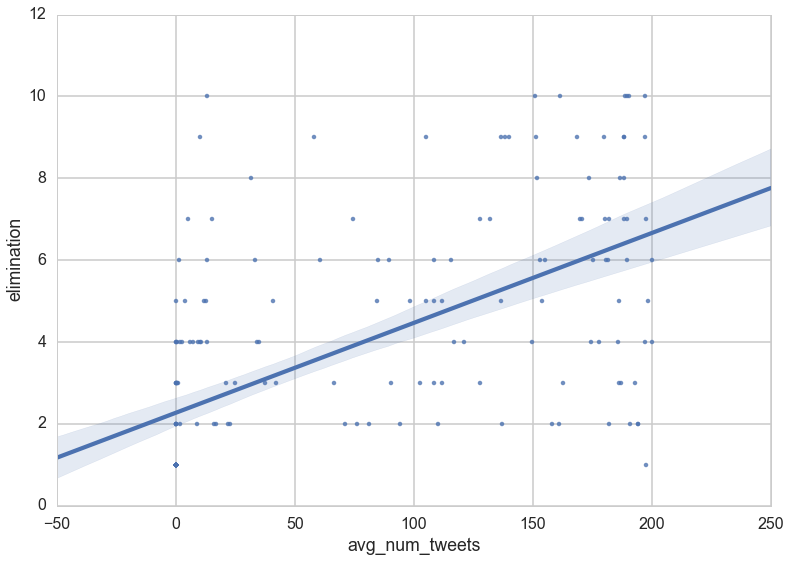

In [9]:
sns.regplot(y="elimination", x="avg_num_tweets", data=df, fit_reg = True)

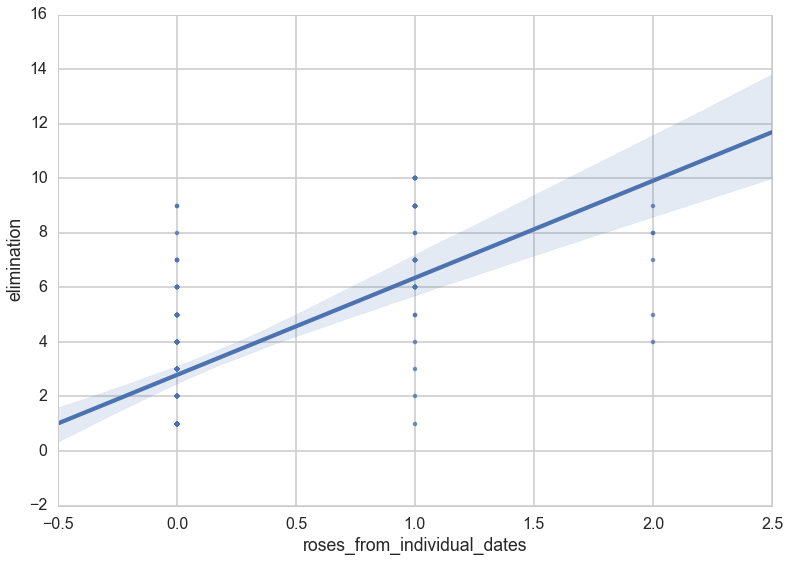

In [10]:
sns.regplot(y="elimination", x="roses_from_individual_dates", data=df, fit_reg = True)

## Looking at the Correlation between Dependent Variables
We attempt to vizualize the correlation between dependent variables that are positively correlated with the independent variables

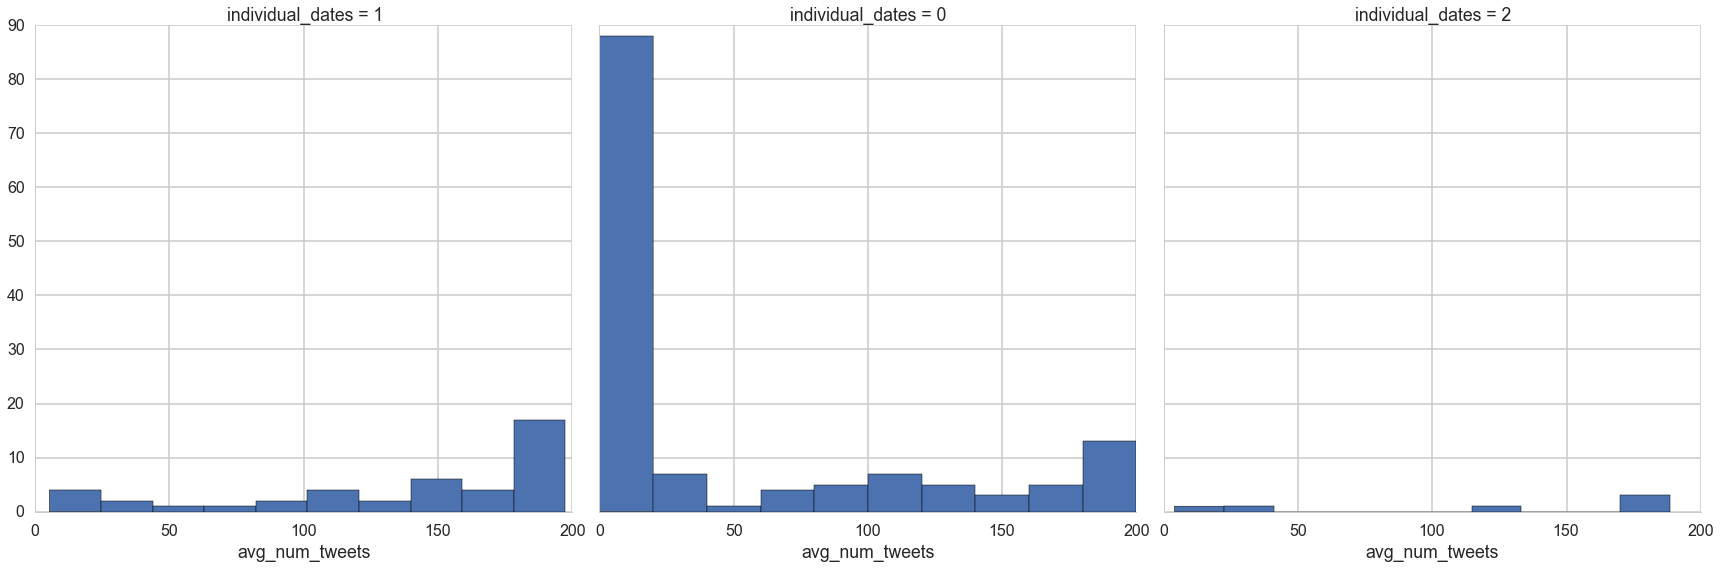

In [11]:
# Plot histogram of number of tweets broken up by individual dates
g = sns.FacetGrid(col="individual_dates", data=df, size=8)
g.map(plt.hist, "avg_num_tweets")

There is a higher distribution of tweets for those individuals that received individual dates.

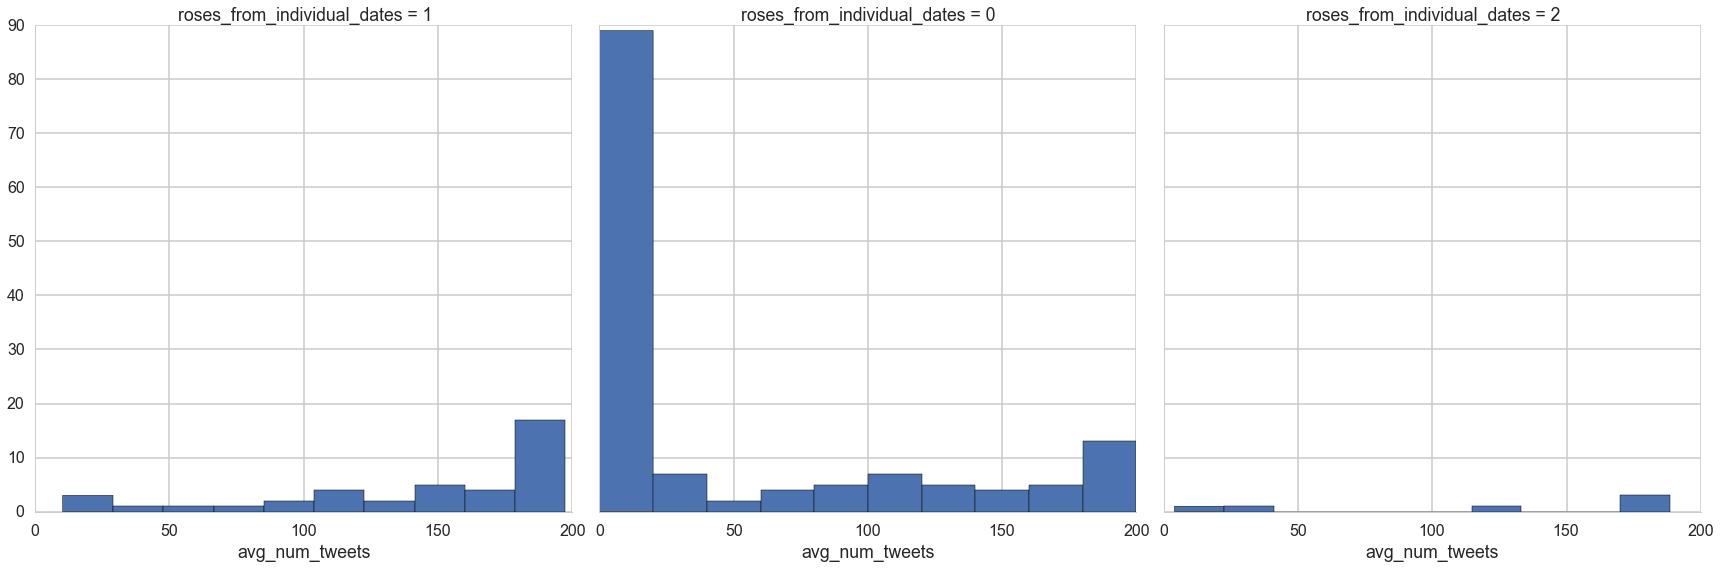

In [15]:
# Plot histogram of number of tweets broken up by individual dates
g = sns.FacetGrid(col="roses_from_individual_dates", data=df, size=8)
g.map(plt.hist, "avg_num_tweets")

Likewise, there is a higher distribution of tweets for those that candidates that received a rose from individual dates.

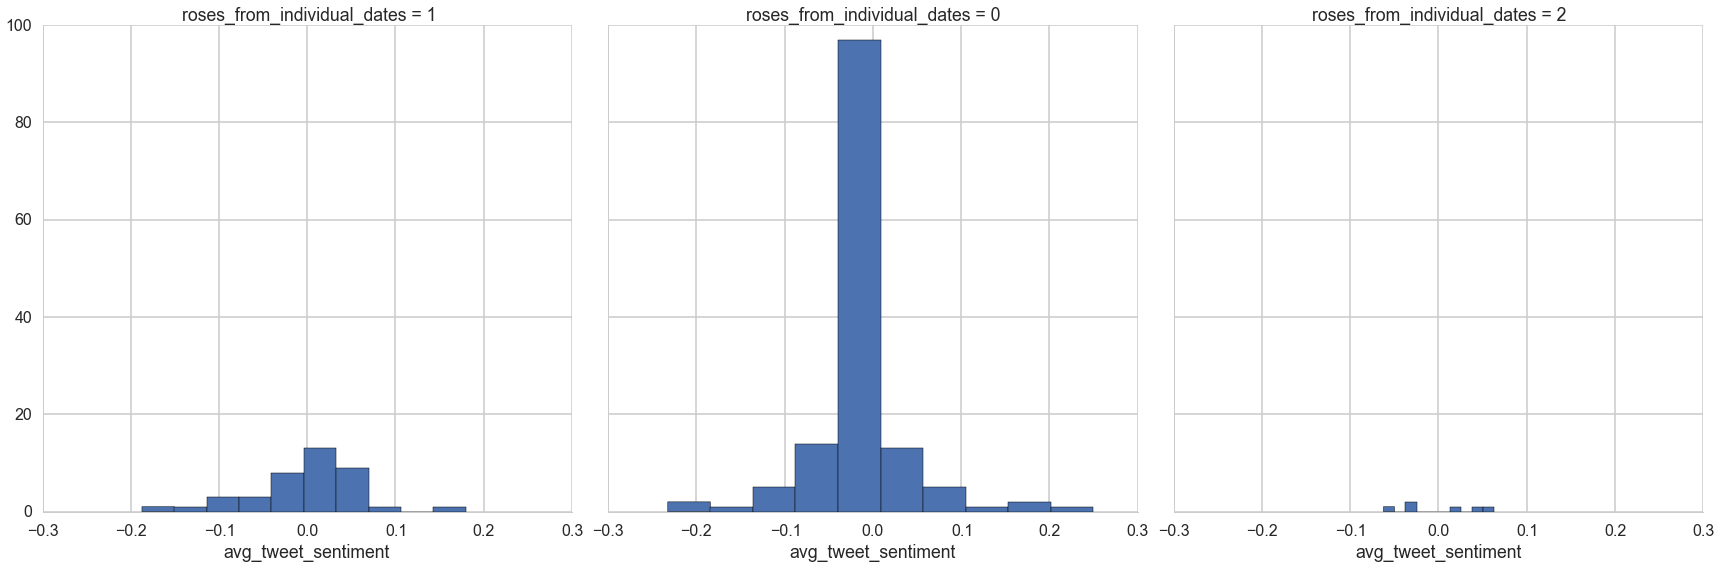

In [16]:
# Plot histogram of number of tweets broken up by 
g = sns.FacetGrid(col="roses_from_individual_dates", data=df, size=8)
g.map(plt.hist, "avg_tweet_sentiment")

We also look to see if roses from individual dates had a higher distribution of contestants that had higher avgerage twitter sentiment. Theres a relatively higher distribution of contestants who received roses from individual dates and  received had higher twitter sentiments. 

## Run Logistic Regression on Data
We want to run a logistics regression to determine the probability of a contestant winning the competition. 

In [17]:
# fit logistic regression model
import statsmodels.api as sm
from statsmodels.formula.api import logit, glm, ols

logit_model = logit('won ~ avg_num_tweets + roses_from_individual_dates',df).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.123483
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    won   No. Observations:                  187
Model:                          Logit   Df Residuals:                      184
Method:                           MLE   Df Model:                            2
Date:                Thu, 10 Dec 2015   Pseudo R-squ.:                  0.2268
Time:                        15:42:48   Log-Likelihood:                -23.091
converged:                       True   LL-Null:                       -29.864
                                        LLR p-value:                  0.001145
===============================================================================================
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -5.5503      1.229     -4.515      0.000        -7.960    -3.141
avg_num_tweets                  0.0126      0.007      1.695      0.090        -0.002     0.027
roses_from_individual_dates     1.3700      0.655      2.092      0.036         0.086     2.654
===============================================================================================
"""

The only dependent variables that were statistically significant were average number of tweets as well as the number roses a contestant received from individual dates. Consequently, our R squared is very low because of the small number of dependent variable used in the regression.

## Run a Linear Regression on Data
We want to run a linear regression to estimate a contestants elimination week

In [21]:
model = ols('elimination ~ avg_num_tweets + roses_from_individual_dates + roses_from_group_dates + pc2 ',df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            elimination   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     54.41
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           1.34e-27
Time:                        15:45:28   Log-Likelihood:                -280.49
No. Observations:                 145   AIC:                             571.0
Df Residuals:                     140   BIC:                             585.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       2.0989      0.187     11.240      0.000         1.730     2.468
avg_num_tweets                  0.0118      0.002      5.310      0.000         0.007     0.016
roses_from_individual_dates     1.7241      0.333      5.184      0.000         1.067     2.382
roses_from_group_dates          1.5851      0.357      4.446      0.000         0.880     2.290
pc2                         -9.162e-05   4.85e-05     -1.891      0.061        -0.000  4.18e-06
==============================================================================
Omnibus:                        6.635   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                9.573
Skew:                           0.197   Prob(JB):                      0.00834
Kurtosis:                       4.195   Cond. No.                     8.32e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The linear regression provides a better model for estimating the episode that a contestant will be eliminated. In addition to average number of tweets and roses from individual dataes, roses from group dates and the principal component 2 were aslo statistically significant. 

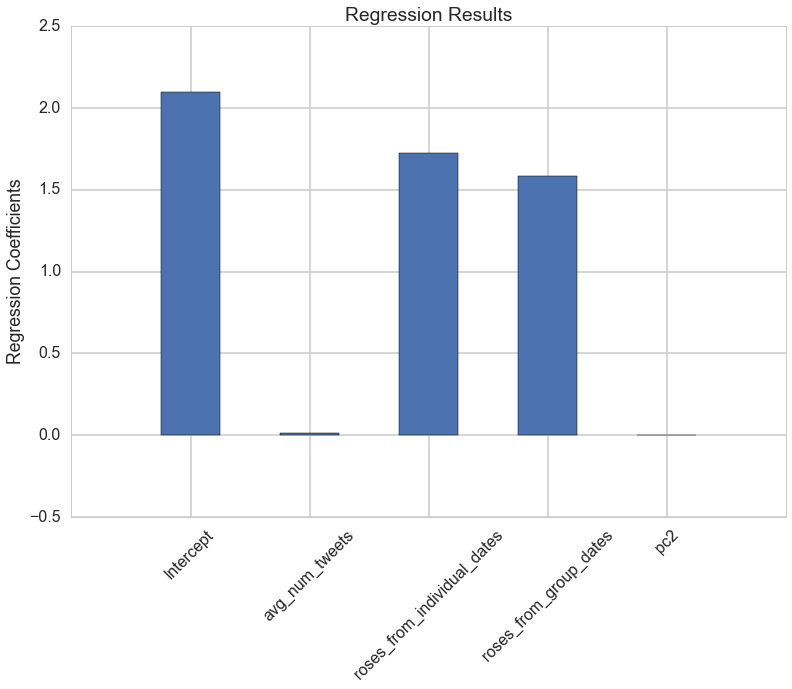

In [22]:
features = list(model.params.keys())
coefs = list(model.params.values)
plt.bar(range(len(features)),coefs, align="center", width=.5)
plt.xticks(range(len(features)), features, rotation=45)
plt.ylabel("Regression Coefficients")
plt.title("Regression Results")
plt.show()

## Breakdown Data by Season
We want to breakdown the data by season to account for the differences in the number of tweets from each season, since the average number of tweets about all contestants should increase from year to year due to twitter's broader addoption. 

In [33]:
seasons_dfs = {}
for sn in range(13,20):
    seasons_dfs[sn] = df_temp[df['season'] == sn]

In [34]:
seasons_dfs[14].head()

,age,avg_num_tweets,avg_tweet_sentiment,distance,elimination,geo_cluster,group_dates,individual_dates,profession,roses_from_group_dates,roses_from_individual_dates,total_tweet_sentiment,total_tweets,won,runner_up
55,23,151.000000,-0.187337,970.915710,10,3,2,1,1,0,1,-1.311356,1057,1,0
56,25,140.142857,0.006997,1638.689701,9,6,1,0,2,1,0,0.048978,981,0,1
57,26,74.666667,-0.048547,1371.988917,7,1,1,1,5,0,1,-0.291285,448,0,0
58,25,108.400000,-0.012097,1453.479117,6,1,1,1,1,0,1,-0.060484,542,0,0
59,23,12.750000,0.014583,965.750991,5,3,2,0,4,0,0,0.058333,51,0,0


In [35]:
seasons_dfs[14].corr().won

avg_num_tweets                 0.454344
avg_tweet_sentiment           -0.453450
distance                      -0.024731
elimination                    0.554021
geo_cluster                   -0.082479
group_dates                    0.374192
individual_dates               0.302849
profession                    -0.223972
roses_from_group_dates        -0.060193
roses_from_individual_dates    0.302849
total_tweet_sentiment         -0.849981
total_tweets                   0.628029
won                            1.000000
runner_up                     -0.041667
Name: won, dtype: float64

It is interesting to note that average and total tweet sentiment have high negative correlations with winning the competition (-0.400540 and -0.849981, respectively), while the average and total number of tweets maintains a high positive correlation with winning the competition (0.454344 and 0.628029, respectively).

In [36]:
seasons_dfs[14].corr().elimination

avg_num_tweets                 0.726037
avg_tweet_sentiment           -0.376984
distance                       0.402683
elimination                    1.000000
geo_cluster                   -0.170559
group_dates                    0.661066
individual_dates               0.501505
profession                    -0.176804
roses_from_group_dates         0.276867
roses_from_individual_dates    0.501505
total_tweet_sentiment         -0.583122
total_tweets                   0.881673
won                            0.554021
runner_up                      0.473494
Name: elimination, dtype: float64

The same phenomena are true when looking at these dependent variables and a contestant's elimination week.

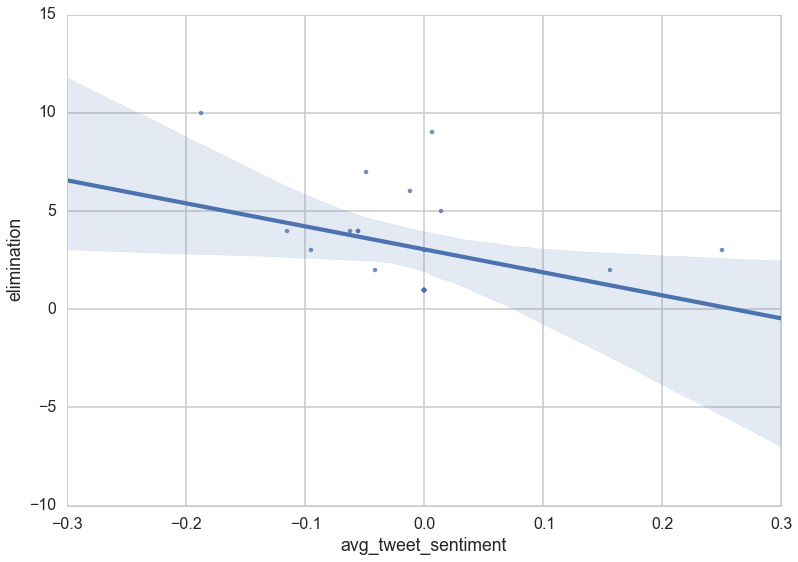

In [37]:
sns.regplot(y="elimination", x="avg_tweet_sentiment", data=seasons_dfs[14], fit_reg = True)

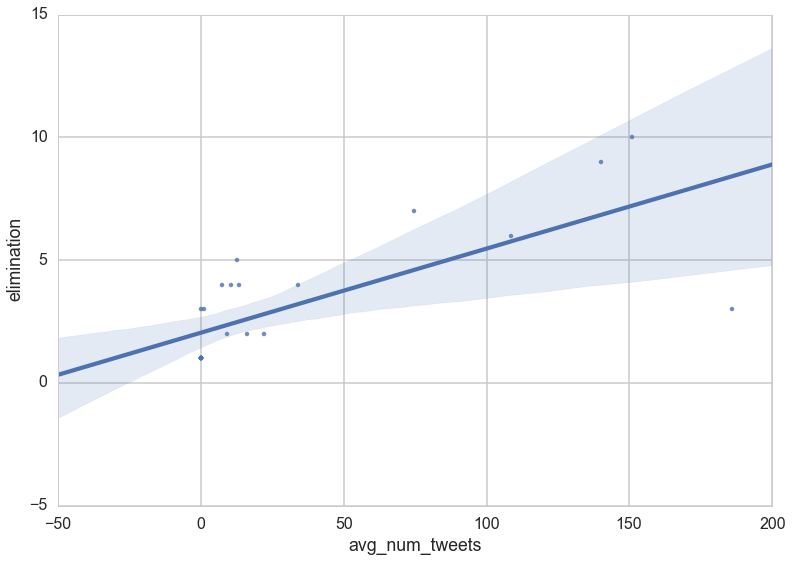

In [38]:
sns.regplot(y="elimination", x="avg_num_tweets", data=seasons_dfs[14], fit_reg = True)

## Breakdown Data by Week
We want to look at the data on a week by week basis to determine the likely hood of a given participant moving on to the next week. We also create a weekly breakdown of the data that treates each week a contestant is on the shoe as unique sample. This allows us to generate more data out of our data set. 

#### Creating DF for weekly data

In [100]:
# Create a dict with the samples pertaining to a given week
weekly_data = []
df_temp = df.copy()
# For each row in the df get the relavint data broken down by week 
for row in df_temp.iterrows():
    contestant = row[1]
    fname = contestant['name'].split(' ')[0]
    season = contestant['season']
    episode_count = date_guide.groupby('Season').Episode.count()[season]
    # for each week get dependent variables that can change by week
    for week in range(1, episode_count):
        c = contestant.copy()
        if week <= contestant['elimination']:
            c['week'] = week
            # get the number of individual dates received
            c['total_individual_dates'] = 0
            # get the number of group dates from received
            c['total_group_dates'] = 0
            # get the number of roses from group dates 
            c['total_group_roses'] = 0
            # get whether contestant had group date last wek
            c['group_date_last_week'] = 0
            # get whether contestant received individual rose in previous week
            c['individual_rose_last_week'] = 0
            # get whether contestant received group rose in previous week
            c['group_rose_last_week'] = 0
            # get the number of tweets about contestant overall
            c['total_tweets'] = 0
            # get the number of tweets from previos week
            c['tweets_last_week'] = 0
            # get the total tweet sentiment
            c['total_tweet_sentiment'] = 0
            # get the tweet sentiment from last week
            c['tweet_sentiment_last_week'] = 0
            
            # iterate through previous weeks to get relevant data
            for w in range(1,week):
                prev_week = w == week - 1
                if str(w) in comp[str(season)]:
                    dates = comp[str(season)][str(w)]
                    if fname in dates:
                        date_type = dates[fname].keys()[0]
                        received_rose = dates[fname][date_type]
                        if 'one' in date_type:
                            c['total_individual_dates'] += 1
                            if prev_week:
                                c['individual_rose_last_week'] = 1
                        if 'group' in date_type:
                            c['total_group_dates'] += 1
                            if prev_week:
                                c['group_date_last_week'] = 1
                            if received_rose:
                                c['total_group_roses'] += 1
                                if prev_week:
                                    c['group_rose_last_week'] = 1
                if fname in twitter[str(season)]:
                    tweet_info = twitter[str(season)][fname]
                    episode_date = date_guide[(date_guide.Episode == w) & (date_guide.Season == season)].Date.values[0]
                    if episode_date in tweet_info:
                        c['total_tweets'] += tweet_info[episode_date]['ntweet']
                        c['total_tweet_sentiment'] += tweet_info[episode_date]['sentiment']
                        if prev_week:
                            c['tweets_last_week'] = tweet_info[episode_date]['ntweet']
                            c['tweet_sentiment_last_week'] = tweet_info[episode_date]['sentiment']
        
        weekly_data.append(c)
          
# create data frame from weekly data
weekly_df = pd.DataFrame(weekly_data)
# create indicator columns
weekly_df['moved_on'] = (weekly_df.elimination > weekly_df.week)*1
weekly_df['received_group_date'] = weekly_df.total_group_dates > 0 
weekly_df['received_individual_date'] = weekly_df.total_individual_dates > 0
weekly_df['received_group_rose'] = weekly_df.total_group_roses > 0
weekly_dftouse = weekly_df.copy().dropna()
weekly_dftouse.head()

,age,avg_num_tweets,avg_tweet_sentiment,distance,elimination,geo_cluster,group_date_last_week,group_dates,group_rose_last_week,hometown,individual_dates,individual_rose_last_week,name,occupation,pc1,pc2,profession,roses_from_group_dates,roses_from_individual_dates,runner_up,season,total_group_dates,total_group_roses,total_individual_dates,total_tweet_sentiment,total_tweets,tweet_sentiment_last_week,tweets_last_week,week,won,moved_on,received_group_date,received_individual_date,received_group_rose
1,24,10.285714,0.071815,226.889927,9,4,0,1,0,"Grand Rapids, Michigan",1,0,Molly Malaney,Department Store Buyer,2629.785937,-1162.096529,3,1,1,1,13,0,0,0,0.000,0,0.000,0,1,0,1,False,False,False
1,24,10.285714,0.071815,226.889927,9,4,0,1,0,"Grand Rapids, Michigan",1,0,Molly Malaney,Department Store Buyer,2629.785937,-1162.096529,3,1,1,1,13,0,0,0,0.125,4,0.125,4,2,0,1,False,False,False
1,24,10.285714,0.071815,226.889927,9,4,1,1,1,"Grand Rapids, Michigan",1,0,Molly Malaney,Department Store Buyer,2629.785937,-1162.096529,3,1,1,1,13,1,1,0,0.875,8,0.750,4,3,0,1,True,False,True
1,24,10.285714,0.071815,226.889927,9,4,0,1,0,"Grand Rapids, Michigan",1,0,Molly Malaney,Department Store Buyer,2629.785937,-1162.096529,3,1,1,1,13,1,1,0,0.875,9,0.000,1,4,0,1,True,False,True
1,24,10.285714,0.071815,226.889927,9,4,0,1,0,"Grand Rapids, Michigan",1,1,Molly Malaney,Department Store Buyer,2629.785937,-1162.096529,3,1,1,1,13,1,1,1,0.575,14,-0.300,5,5,0,1,True,True,True


In [101]:
weekly_dftouse.shape

(508, 34)

In [102]:
weekly_dftouse.corr()['moved_on']

avg_num_tweets                 0.321875
avg_tweet_sentiment           -0.022367
distance                      -0.054171
elimination                    0.515859
geo_cluster                   -0.016320
group_date_last_week          -0.000725
group_dates                    0.369777
group_rose_last_week           0.075066
individual_dates               0.282230
individual_rose_last_week      0.068162
pc1                           -0.033556
pc2                           -0.102677
profession                     0.014756
roses_from_group_dates         0.261414
roses_from_individual_dates    0.275535
runner_up                      0.156745
season                         0.094717
total_group_dates             -0.052541
total_group_roses              0.110415
total_individual_dates         0.063175
total_tweet_sentiment          0.055189
total_tweets                   0.072391
tweet_sentiment_last_week      0.025518
tweets_last_week               0.161100
week                          -0.015340


In [170]:
pred_col = [
            #'total_tweets',
            'total_group_dates',
            'total_individual_dates',
            'roses_from_group_dates',
            'roses_from_individual_dates',
            'tweets_last_week',
            #'group_rose_last_week',
            #'individual_rose_last_week',
            #'group_date_last_week',
            #'total_tweet_sentiment',
            #'tweet_sentiment_last_week',
            #'week',
            #'pc1',
            'pc2'
           ]

regression_formula = 'moved_on ~'
for i, dep in enumerate(pred_col):
    if i > 0:
        regression_formula += '+'
    
    regression_formula += ' '+dep+' '

logit_model = logit(regression_formula, weekly_dftouse).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.472739
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               moved_on   No. Observations:                  508
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            6
Date:                Thu, 10 Dec 2015   Pseudo R-squ.:                  0.1835
Time:                        17:10:05   Log-Likelihood:                -240.15
converged:                       True   LL-Null:                       -294.12
                                        LLR p-value:                 5.490e-21
===============================================================================================
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       0.4691      0.149      3.140      0.002         0.176     0.762
total_group_dates              -0.5534      0.124     -4.478      0.000        -0.796    -0.311
total_individual_dates         -1.5877      0.551     -2.880      0.004        -2.668    -0.507
roses_from_group_dates          1.4685      0.337      4.351      0.000         0.807     2.130
roses_from_individual_dates     2.0003      0.474      4.224      0.000         1.072     2.929
tweets_last_week                0.0039      0.002      2.303      0.021         0.001     0.007
pc2                         -9.892e-05   4.03e-05     -2.453      0.014        -0.000 -1.99e-05
===============================================================================================
"""

### Cross-Validation on Data

In [171]:
#Make training/test masks
itrain, itest = train_test_split(xrange(weekly_dftouse.shape[0]), train_size=0.7)
mask=np.ones(weekly_dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

# make sure we didn't get unlucky in our mask selection
print "Percentage of contestants that moved on in training set:", np.mean(weekly_dftouse.moved_on[mask])
print "Percentage of contestants that moved on in test set:", np.mean(weekly_dftouse.moved_on[~mask])

Percentage of contestants that moved on in training set: 0.746478873239
Percentage of contestants that moved on in test set: 0.705882352941


using mask
BEST {'C': 1.0} 0.738028169014 [mean: 0.69577, std: 0.03696, params: {'C': 0.001}, mean: 0.69859, std: 0.03513, params: {'C': 0.01}, mean: 0.73239, std: 0.02136, params: {'C': 0.1}, mean: 0.73803, std: 0.02471, params: {'C': 1.0}, mean: 0.73803, std: 0.02770, params: {'C': 10.0}, mean: 0.73803, std: 0.02770, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.76
Accuracy on test data:     0.75
[[ 10  35]
 [  4 104]]
########################################################


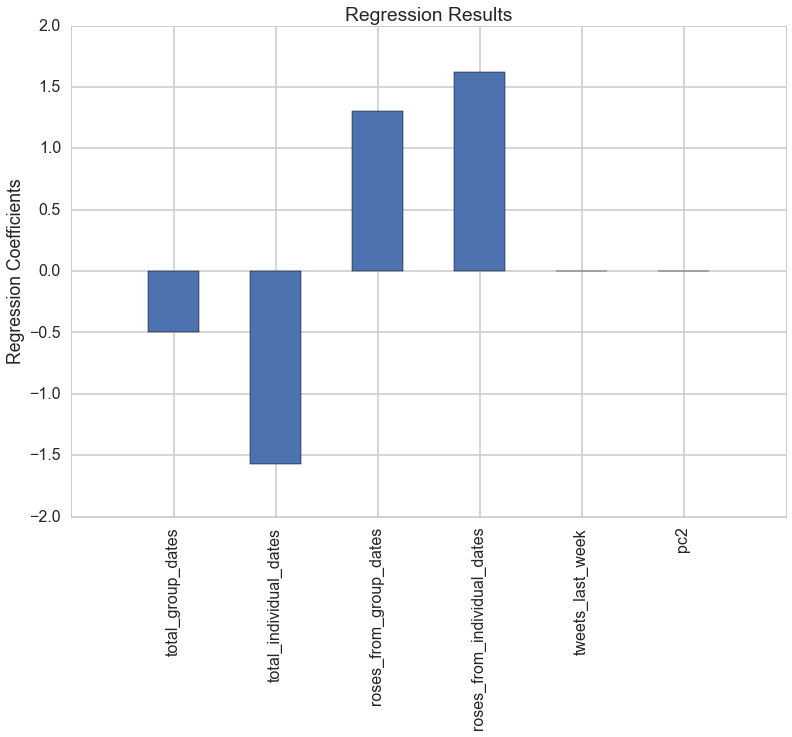

In [172]:
#Find the best logistic classifier - report accuracy
CC = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clf, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), \
                                                   CC, weekly_dftouse, pred_col, \
                                                   'moved_on',1, mask=mask, n_folds=3)
plt.bar(range(len(clf.coef_[0])),clf.coef_[0], align="center", width=.5)
plt.xticks(range(len(clf.coef_[0])), pred_col, rotation=90)
plt.ylabel("Regression Coefficients")
plt.title("Regression Results")
plt.show()

In [173]:
clf.fit(Xtrain, ytrain)
pred_train = clf.predict(Xtrain)
pred_test = clf.predict(Xtest)

In [174]:
Xnames = pred_col
Xnames.remove('pc2')
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       weekly_dftouse, Xnames, 'moved_on', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask
BEST {'n_estimators': 1} 0.823216030793 [mean: 0.82322, std: 0.04396, params: {'n_estimators': 1}, mean: 0.72248, std: 0.05452, params: {'n_estimators': 2}, mean: 0.75971, std: 0.06275, params: {'n_estimators': 3}, mean: 0.80194, std: 0.02756, params: {'n_estimators': 4}, mean: 0.81058, std: 0.02699, params: {'n_estimators': 5}, mean: 0.80456, std: 0.03965, params: {'n_estimators': 6}, mean: 0.81352, std: 0.03099, params: {'n_estimators': 7}, mean: 0.79833, std: 0.04280, params: {'n_estimators': 8}, mean: 0.81109, std: 0.03993, params: {'n_estimators': 9}, mean: 0.79006, std: 0.01700, params: {'n_estimators': 10}, mean: 0.80991, std: 0.03351, params: {'n_estimators': 11}, mean: 0.79610, std: 0.02945, params: {'n_estimators': 12}, mean: 0.80654, std: 0.02321, params: {'n_estimators': 13}, mean: 0.81773, std: 0.02789, params: {'n_estimators': 14}, mean: 0.80949, std: 0.04007, params: {'n_estimators': 15}, mean: 0.79779, std: 0.01770, params: {'n_estimators': 16}, mean: 0.80263

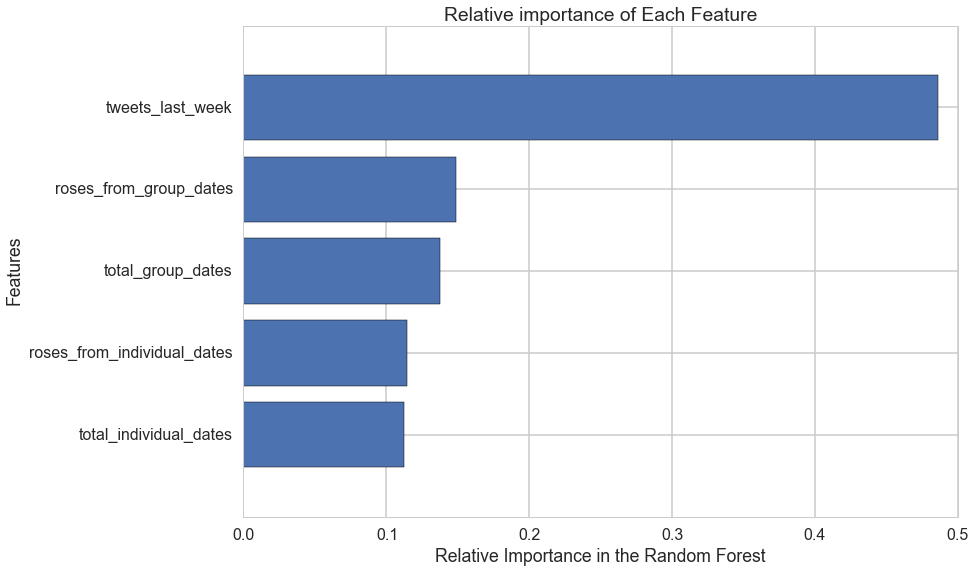

In [176]:
importance_list = clfForest.feature_importances_
name_list = Xnames
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

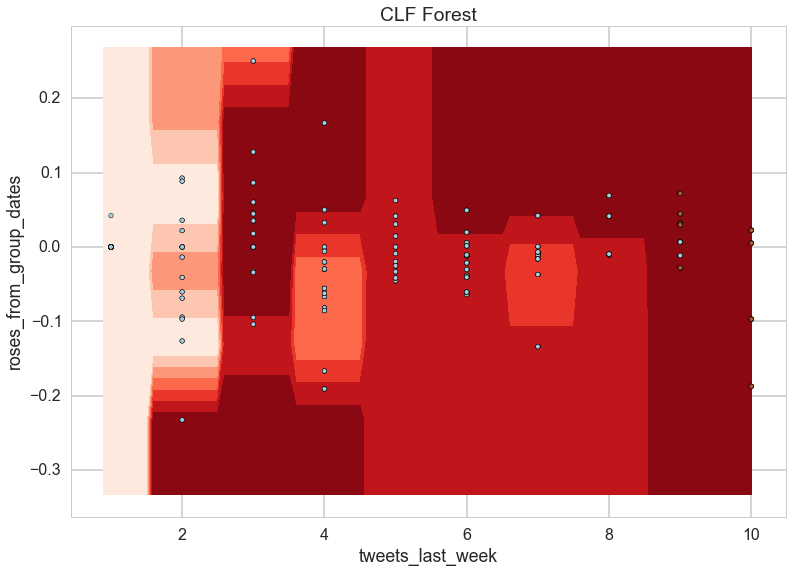

In [184]:
imp_cols = clfForest.feature_importances_.argsort()[::-1][0:2]
imp_cols
X_imp = weekly_dftouse[imp_cols].values
Y = weekly_dftouse.moved_on.values

plt.title('CLF Forest')
plt.xlabel(Xnames[imp_cols[0]])
plt.ylabel(Xnames[imp_cols[1]])
plot_decision_surface(clfForest, X_imp, Y)

In [207]:
week_df = {}

for week in range(1,8):
    week_df[week] = weekly_dftouse[weekly_dftouse.week == week]

In [208]:
#Make training/test masks
itrain, itest = train_test_split(xrange(week_df[2].shape[0]), train_size=0.7)
mask=np.ones(week_df[2].shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

# make sure we didn't get unlucky in our mask selection
print "Percentage of contestants that won in training set:", np.mean(week_df[2].moved_on[mask])
print "Percentage of contestants that won in test set:", np.mean(week_df[2].moved_on[~mask])

Percentage of contestants that won in training set: 0.820895522388
Percentage of contestants that won in test set: 0.862068965517


using mask
BEST {'C': 10.0} 0.820895522388 [mean: 0.53731, std: 0.25494, params: {'C': 0.001}, mean: 0.74627, std: 0.07005, params: {'C': 0.01}, mean: 0.74627, std: 0.07005, params: {'C': 0.1}, mean: 0.76119, std: 0.07826, params: {'C': 1.0}, mean: 0.82090, std: 0.00373, params: {'C': 10.0}, mean: 0.82090, std: 0.00373, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.86
[[ 0  4]
 [ 0 25]]
########################################################


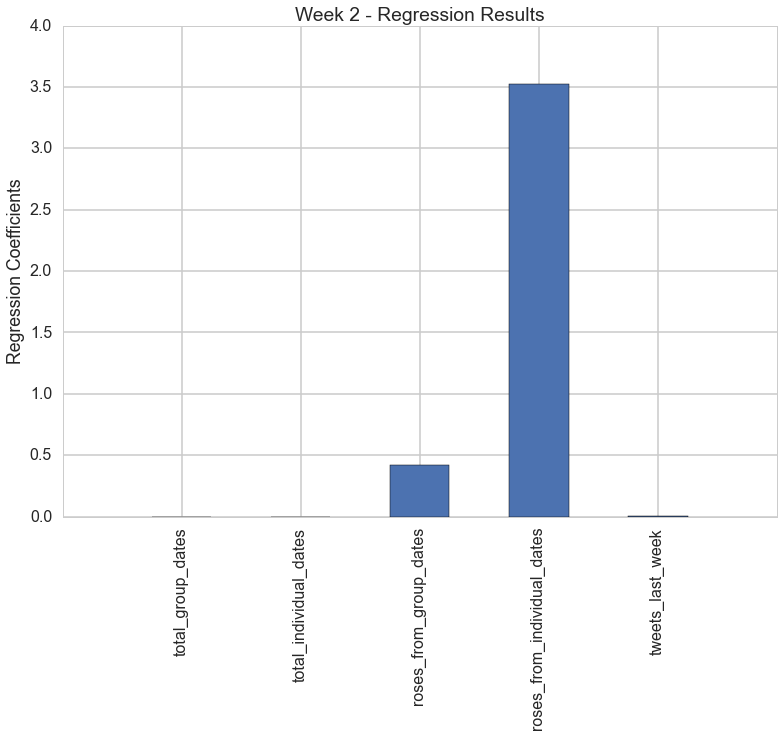

In [209]:
#Find the best logistic classifier - report accuracy
CC = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clf, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), \
                                                   CC, week_df[2], pred_col, \
                                                   'moved_on',1, mask=mask, n_folds=3)
plt.bar(range(len(clf.coef_[0])),clf.coef_[0], align="center", width=.5)
plt.xticks(range(len(clf.coef_[0])), pred_col, rotation=90)
plt.ylabel("Regression Coefficients")
plt.title("Week 2 - Regression Results")
plt.show()

### Decision Tree Classification

In [20]:
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, df_temp, 
                                                     ['avg_tweet_sentiment', 'group_dates'],'won', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 1, 'min_samples_leaf': 1} 0.0 [mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.00000, std: 0.00000, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: 0.00000, std: 0.00000, params: {'max_depth': 2, 'min_samples_leaf': 2}, mean: 0.00000, std: 0.00000, params: {'max_depth': 2, 'min_samples_leaf': 3}, mean: 0.00000, std: 0.00000, params: {'max_depth': 2, 'min_samples_leaf': 4}, mean: 0.00000, std: 0.00000, params: {'max_depth': 2, 'min_samples_leaf': 5}, mean: 0.00000, std: 0.00000, params: {'max_depth': 2, 'min_samples_leaf': 6}, mea

/Users/hopemason/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hopemason/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hopemason/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hopemason/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hopemason/anaconda/lib/python2.7/site-package

In [21]:
#plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, lab = ['Average Number of Tweets', 'Number of Roses from Group Dates'], alpha = 1, plot_train = False)

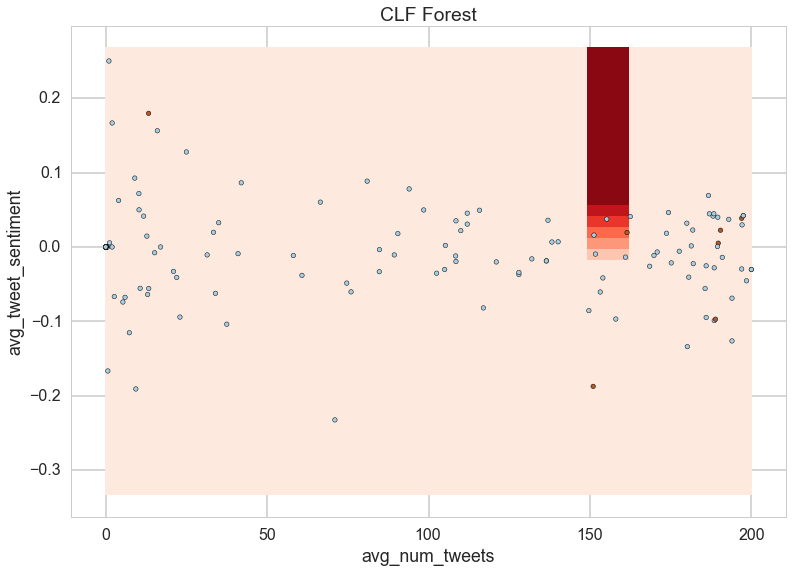

In [39]:
plt.title('CLF Forest')
plt.xlabel(Xnames[imp_cols[0]])
plt.ylabel(Xnames[imp_cols[1]])
plot_decision_surface(clfForest, X_imp, Y)

In [1]:
tweet_df = df[['avg_num_tweets','std_num_tweets','avg_tweet_sentiment','std_tweet_sentiment','elimination']]
def change_winner_runnerup(v):
    if v == "Winner":
        return 10
    elif v == "Runner-up":
        return 9
    elif 'week' in v.lower():
        for num in range(0,10):
            if str(num) in v:
                return num
    else:
        return v
tweet_df['elimination'] = tweet_df['elimination'].apply(change_winner_runnerup)
tweet_df['elimination'] = tweet_df['elimination'].astype('int')
tweet_df.head()

NameError: name 'df' is not defined